## Nutrient Demands



### Introduction



In our last project we used data to estimate systems of food demand
using different datasets.  An output from that project was as set of
`cfe.Regression` objects; these bundle together both data and the results
from the demand system estimation, and can be used for prediction as
well.

Here we&rsquo;ll explore some of the uses of the `cfe.Regression` class, using
an instance created previously (as in Project 3).

After having estimated a demand system using data from our favorite country, we can imagine different counterfactual scenarios.  What if prices were different?  What if we give a cash transfer to a household?  What if school fees reduce the budget for food?  What are the consequences of any of these for diet & nutrition?

If you don&rsquo;t already have the latest version of the `CFEDemands` package
installed, grab it, along with some dependencies:



In [1]:
#!pip install -r requirements.txt

In [2]:
import pandas as pd
import cfe.regression as rgsn

Missing dependencies for OracleDemands.


### Data



We&rsquo;ll get data from two places.  First, basic data, including a food
 conversion table and recommended daily intakes table can be found in
 a google spreadsheet.

Here are addresses of google sheets for different dataframes for the
case of Uganda:



In [3]:
InputFiles = {'Expenditures':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Expenditures (2019-20)'),
              'Prices':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','Prices'),
              'HH Characteristics':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','HH Characteristics'),
              'FCT':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','FCT'),
              'RDI':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),}

#### Prices, FCT, RDI



In [5]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get prices
p = get_clean_sheet(InputFiles['Prices'][0],
                    sheet=InputFiles['Prices'][1])

if 'm' not in p.columns:  # Supply "market" indicator if missing
    p['m'] = 1

p = p.set_index(['t','m'])
p.columns.name = 'j'

p = p.apply(lambda x: pd.to_numeric(x,errors='coerce'))
p = p.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.
Key available for students@eep153.iam.gserviceaccount.com.


#### Pre-estimated Demand Systems



An instance `r` of `cfe.Regression` can be made persistent with
 `r.to_pickle('my_result.pickle')`, which saves the instance &ldquo;on disk&rdquo;, and can be loaded using `cfe.regression.read_pickle`.  We use  this method below to load data and demand system previously estimated for Uganda:



In [6]:
r = rgsn.read_pickle('uganda_2019-20.pickle')  # Assumes you've already set this up e.g., in Project 3

#### Reference Prices



Choose reference prices.  Here we&rsquo;ll choose a particular year, and average prices across markets.  If you wanted to focus on particular market you&rsquo;d do this differently.



In [7]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.xs('2019-20',level='t').mean()
pbar = pbar[r.beta.index] # Only use prices for goods we can estimate

#### Budgets



Get food budget for all households, then find median budget:



In [8]:
import numpy as np

xhat = r.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

#### Food Quantities



Get quantities of food by dividing expenditures by prices:



In [9]:
qhat = (xhat.unstack('j')/pbar).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

qhat

,,j,Beans,Beef,Biscuits,Bread,Cabbages,Cassava,Chapati,Cooking Oil,Dodo,Eggs,...,Rice,Salt,Sim Sim,Soda,Sorghum,Sweet Bananas,Sweet Potatoes,Tea,Tomatoes,Waragi
i,t,m,,,,,,,,,,,,,,,,,,,,,
00c9353d8ebe42faabf5919b81d7fae7,2019-20,Eastern,0.908344,0.873736,0.278641,0.679694,0.542311,7.076232,1.225904,0.768595,2.102513,1.300093,...,1.904098,0.210626,0.169969,0.828589,1.032246,1.855447,9.106649,0.020781,2.065636,0.547677
0d0e29faff394154a69562b4527b48b8,2019-20,Eastern,0.630212,0.704890,0.332241,0.547917,0.386812,4.651378,1.117598,0.688879,1.406102,1.218035,...,1.200659,0.159736,0.182561,0.863060,0.734592,1.631692,5.637060,0.015357,1.934006,1.241320
0e03e253c35d4333a1ffad2df9d38850,2019-20,Eastern,0.613338,0.545572,0.129055,0.371819,0.290441,5.161206,0.725595,0.516824,1.212362,0.887650,...,0.853833,0.156937,0.098278,0.419683,0.466584,0.810668,5.261903,0.011435,1.357342,0.826227
1013000201,2019-20,Central,0.962721,1.172347,1.375567,1.003591,0.523225,3.037451,1.864472,0.697341,2.265463,1.793179,...,1.355894,0.143342,0.210153,1.689991,0.925546,2.539598,4.600645,0.029232,2.506099,0.878415
1013000202,2019-20,Central,0.783036,0.588576,0.214716,0.411769,0.272860,3.188167,0.608036,0.379958,1.262848,1.067309,...,0.643904,0.167656,0.066803,0.347818,0.351393,0.987588,3.197720,0.013198,1.131102,0.537512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bfdf0d66403440ceab439b1e1c47cdea,2019-20,Eastern,1.474756,1.084495,0.410866,0.612537,0.532731,9.631213,1.567699,0.878762,2.330314,1.518435,...,2.209271,0.280835,0.231877,1.055073,1.601185,3.907814,13.453670,0.018543,2.189298,1.929582
c33f6cb57d9849949e08a7350dabb829,2019-20,Central,0.642402,0.678325,0.525649,0.425417,0.313321,2.507347,0.838033,0.409256,1.410044,1.156874,...,0.680075,0.119045,0.100621,0.794967,0.405909,1.185200,3.030198,0.017108,1.345186,0.515554
d10a687889de469687377204195f3db0,2019-20,Western,1.293502,0.857205,0.451531,0.512783,0.420744,4.915754,0.880891,0.635583,1.252812,1.400779,...,0.730574,0.249491,0.527720,0.737261,1.414265,1.657020,3.251340,0.025992,2.019768,0.922988


Finally, define a function to change a single price in the vector $p$:



In [10]:
def my_prices(p0,p=pbar,j='Millet'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

### Demands



#### Demand functions



<IPython.core.display.Javascript object>


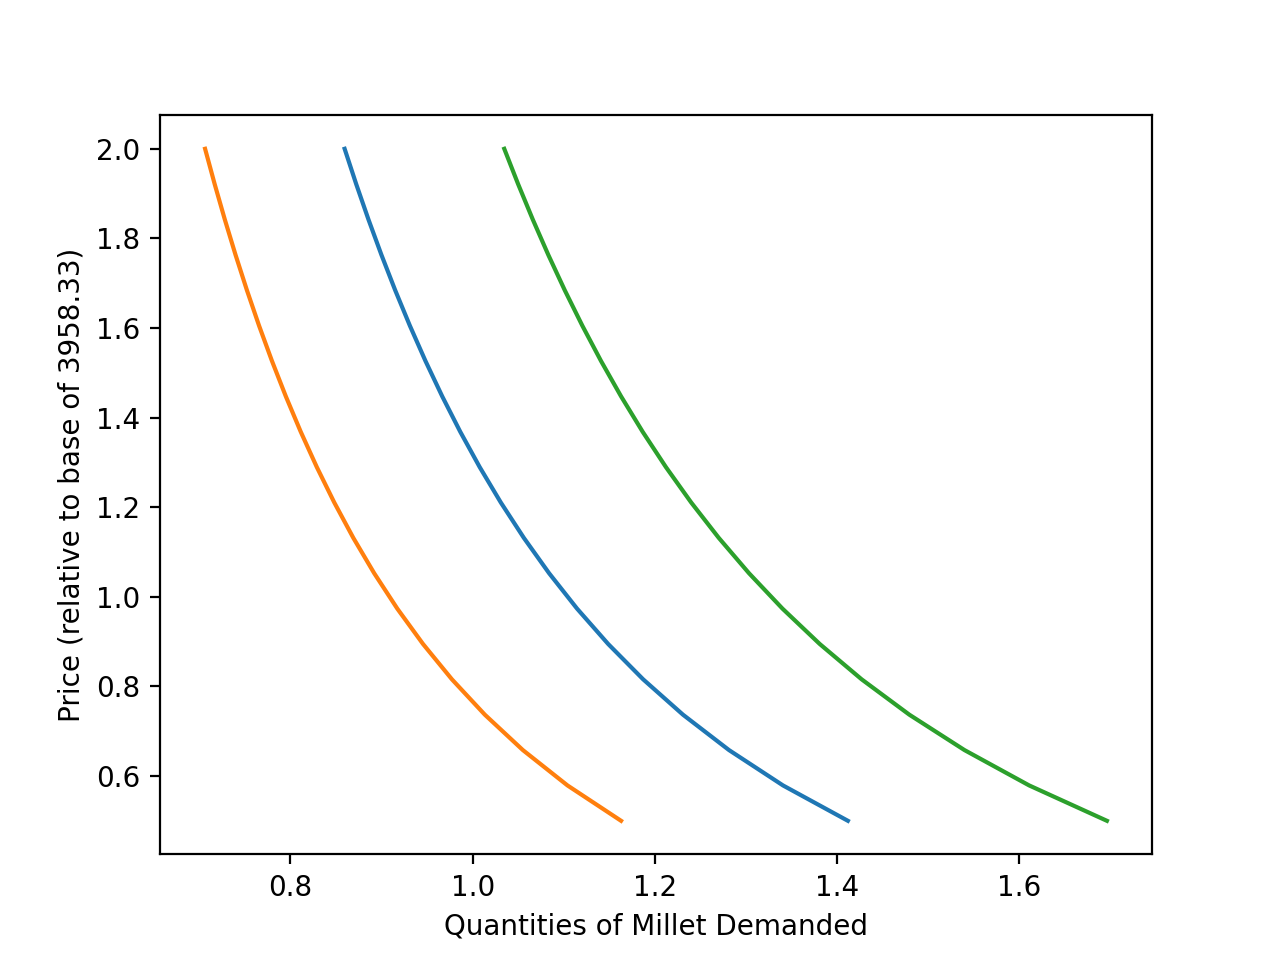

Text(0.5, 0, 'Quantities of Millet Demanded')

In [11]:
import matplotlib.pyplot as plt
%matplotlib notebook

use = 'Millet'  # Good we want demand curve for

# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([r.demands(xref,my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([r.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([r.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

#### Engel Curves



<IPython.core.display.Javascript object>


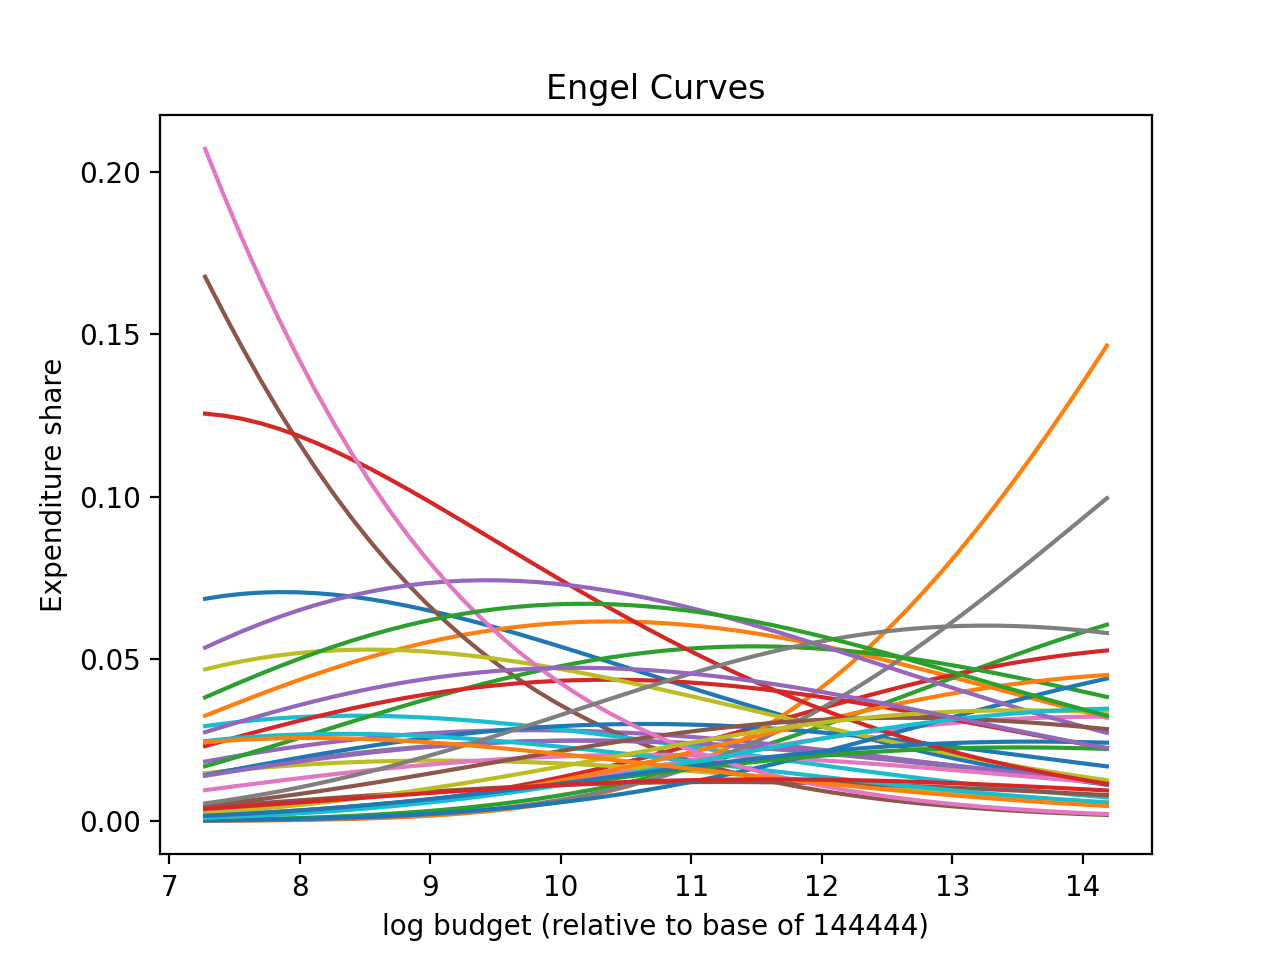

Text(0.5, 1.0, 'Engel Curves')

In [12]:
fig,ax = plt.subplots()

scale = np.geomspace(.01,10,50)

ax.plot(np.log(scale*xref),[r.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

### Mapping to Nutrients



We&rsquo;ve seen how to map prices and budgets into vectors of consumption
 quantities using `cfe.Regression.demands`.  Next we want to think about
 how to map these into bundles of *nutrients*.  The information needed
 for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
 such as the [USDA Food Data Central](https://fdc.nal.usda.gov/)).    We&rsquo;ve already grabbed an FCT, let&rsquo;s take a look:



In [13]:
fct

n,Energy,Protein,Fiber,Folate,Calcium,Carbohydrate,Iron,Niacin,Riboflavin,Thiamin,Vitamin A,Vitamin B-12,Vitamin B-6,Vitamin C,Zinc
j,,,,,,,,,,,,,,,
Avocado,1600,20.0,70.0,810,120,85.0,6.0,17.38,1.30,0.67,70,0.0,2.57,100,6.0
Beans (dry),1700,98.0,60.0,500,580,325.0,30.0,7.00,1.20,3.40,0,0.0,2.15,10,8.0
Beans (fresh),3470,214.0,160.0,5250,1130,626.0,51.0,11.74,2.12,7.13,0,0.0,4.74,63,23.0
Beef,2510,182.0,0.0,60,70,0.0,19.0,31.50,1.60,0.90,0,28.9,3.80,0,37.0
Beef (roasted),2910,264.0,0.0,70,90,0.0,27.0,37.20,2.20,0.90,0,24.7,3.40,0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tomatoes,180,9.0,10.0,150,100,39.0,3.0,5.94,0.19,0.37,420,0.0,0.80,127,2.0
Waragi,2630,0.0,0.0,0,0,0.0,0.0,0.00,0.00,0.00,0,0.0,0.00,0,0.0
Watermelon,300,6.1,4.0,30,70,75.5,2.4,1.78,0.21,0.33,280,0.0,0.45,81,1.0


We need the index of the Food Conversion Table (FCT) to match up with
 the index of the vector of quantities demanded.   To manage this we
 make use of the `align` method for `pd.DataFrames`:



In [14]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(qhat.T,axis=0,join='inner')
print(fct0.index)

Index(['Beef', 'Biscuits', 'Bread', 'Cabbages', 'Chapati', 'Cooking Oil',
       'Dodo', 'Eggs', 'Mangos', 'Millet', 'Onions', 'Oranges', 'Peas', 'Pork',
       'Sim Sim', 'Soda', 'Sorghum', 'Sweet Bananas', 'Tomatoes', 'Waragi'],
      dtype='object', name='j')


Now, since rows of `fct0` and `c0` match, we can obtain nutritional
 outcomes from the inner (or dot, or matrix) product of the transposed
 `fct0` and `c0`:



In [15]:
# The @ operator means matrix multiply
N = fct0.T@c0

N  #NB: Uganda quantities are for previous 7 days

i,00c9353d8ebe42faabf5919b81d7fae7,0d0e29faff394154a69562b4527b48b8,0e03e253c35d4333a1ffad2df9d38850,1013000201,1013000202,1013000204,1021000108,1021000109,1021000111,1021000506,...,a98bebba177243668464e31f6d2bb92d,ab5cbcbe0e14402aae73b91c6917a595,acb16f9b068549d8a80a37c9d638742f,ad9b7c4ba614444bb8004eb658693c9f,bfd8253bd59c4f3199fb4b83b9cee7a6,bfdf0d66403440ceab439b1e1c47cdea,c33f6cb57d9849949e08a7350dabb829,d10a687889de469687377204195f3db0,d24fa50d02c041969a42102d8ebdadc9,e07bc322c4884559b4b8ca75c945dd3e
t,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,...,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20,2019-20
m,Eastern,Eastern,Eastern,Central,Central,Central,Central,Central,Central,Central,...,Western,Eastern,Western,Eastern,Eastern,Eastern,Central,Western,Eastern,Northern
n,,,,,,,,,,,,,,,,,,,,,
Energy,34279.310477,32355.450360,22060.620296,46690.228262,19896.924750,79031.265805,24161.351849,48592.831111,45061.192428,35952.286939,...,102102.378612,31487.979190,54039.668071,75711.958741,62061.011135,51445.085092,24093.078697,37178.769958,67803.612157,53951.989701
Protein,958.221727,848.291671,606.550231,1430.201590,655.967358,2198.620670,782.230906,1479.898620,1285.913078,1068.267730,...,2907.041311,841.020327,1518.187079,2098.488083,1690.398619,1308.048475,780.167783,1107.343632,1764.450600,1597.985807
Fiber,451.701082,385.098175,257.000644,521.047820,226.641875,820.025958,274.048694,549.012040,493.144652,406.829999,...,1526.727586,389.781560,722.203037,1152.818738,797.202890,737.391004,266.644270,486.270718,889.695022,791.659163
Folate,7937.213883,6480.064258,4645.968388,10440.967806,4727.570937,16215.674085,5554.150916,10309.673309,9113.777735,7581.336834,...,19133.901097,6304.773764,9998.610193,17553.980356,12673.612232,10882.814392,5540.400994,7314.852569,13702.791000,10305.697729
Calcium,12256.152457,10058.249503,7137.179975,15231.774571,6834.371519,24477.484390,8241.308747,14937.404781,14341.457653,11283.826862,...,31937.343051,9701.681983,17438.516919,28109.155141,19748.143513,15719.899096,8124.459399,13157.113011,21487.304482,15545.830657
Carbohydrate,4481.664562,3865.191413,2496.602744,6119.095183,2261.808888,10605.864712,2751.507369,5908.342334,5410.644500,4124.866224,...,14853.094826,3933.152678,7008.748229,10931.119046,8174.556250,7011.353879,2909.292425,4527.807772,9138.590392,7931.868204
Iron,260.052962,214.972363,149.482896,347.948975,150.080223,554.531545,180.492003,353.287413,319.227503,255.969434,...,864.752802,215.977115,429.298229,575.416160,448.933480,337.713121,180.999168,314.095233,480.181213,444.142268


Of course, since we can compute the nutritional content of a vector of
 consumption goods `c0`, we can also use our demand functions to
 compute nutrition as a *function* of prices and budget.



In [16]:
def nutrient_demand(x,p):
    c = r.demands(x,p)
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    N = N.loc[~N.index.duplicated()]
    
    return N

With this `nutrient_demand` function in hand, we can see how nutrient
 outcomes vary with budget, given prices:



<IPython.core.display.Javascript object>


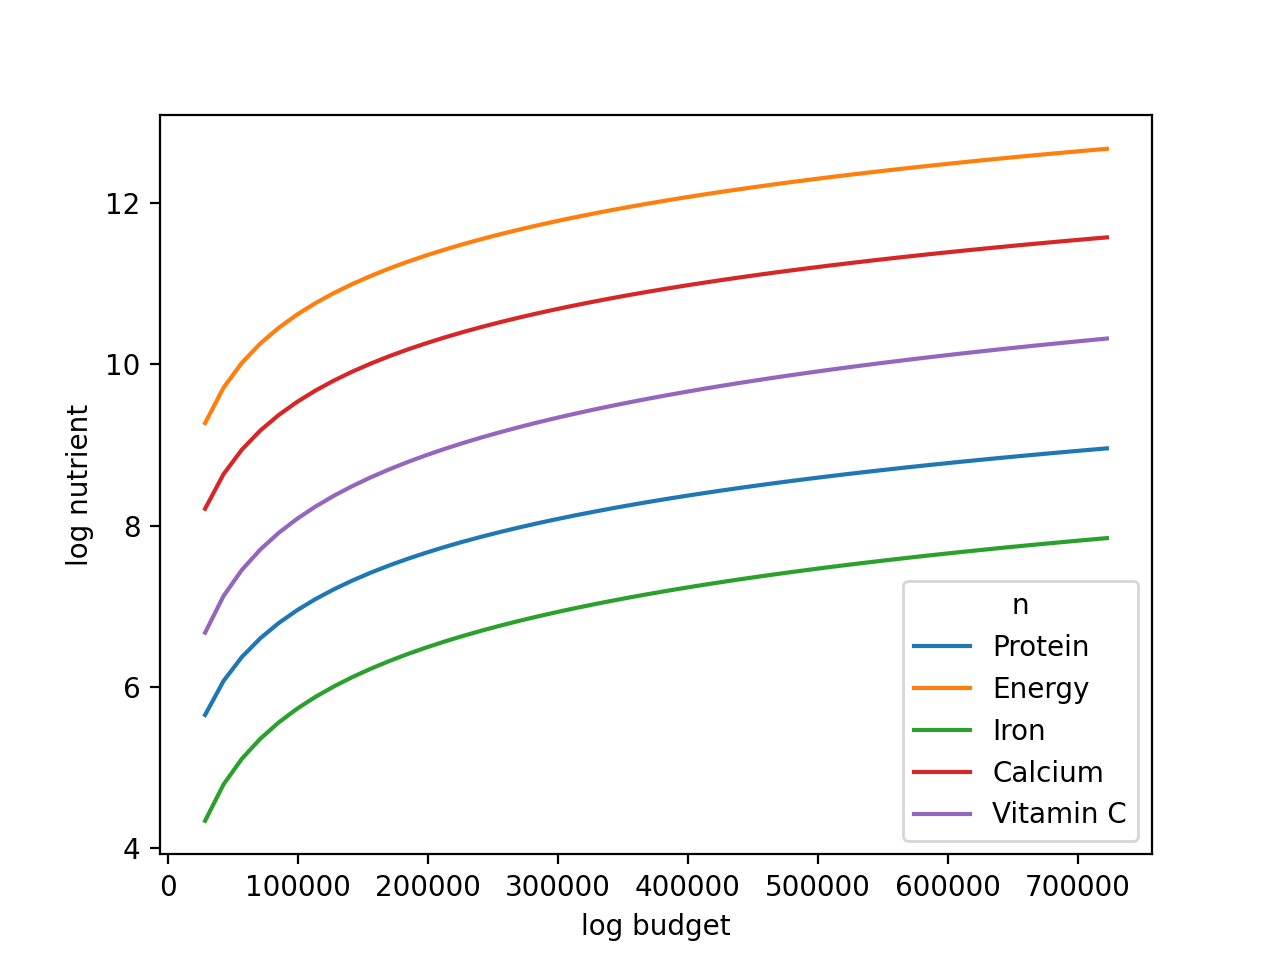

Text(0, 0.5, 'log nutrient')

In [17]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(xref/5,xref*5,50)

UseNutrients = ['Protein','Energy','Iron','Calcium','Vitamin C']

df = pd.concat({myx:np.log(nutrient_demand(myx,pbar))[UseNutrients] for myx in X},axis=1).T
ax = df.plot()

ax.set_xlabel('log budget')
ax.set_ylabel('log nutrient')

Now how does nutrition vary with prices?



<IPython.core.display.Javascript object>


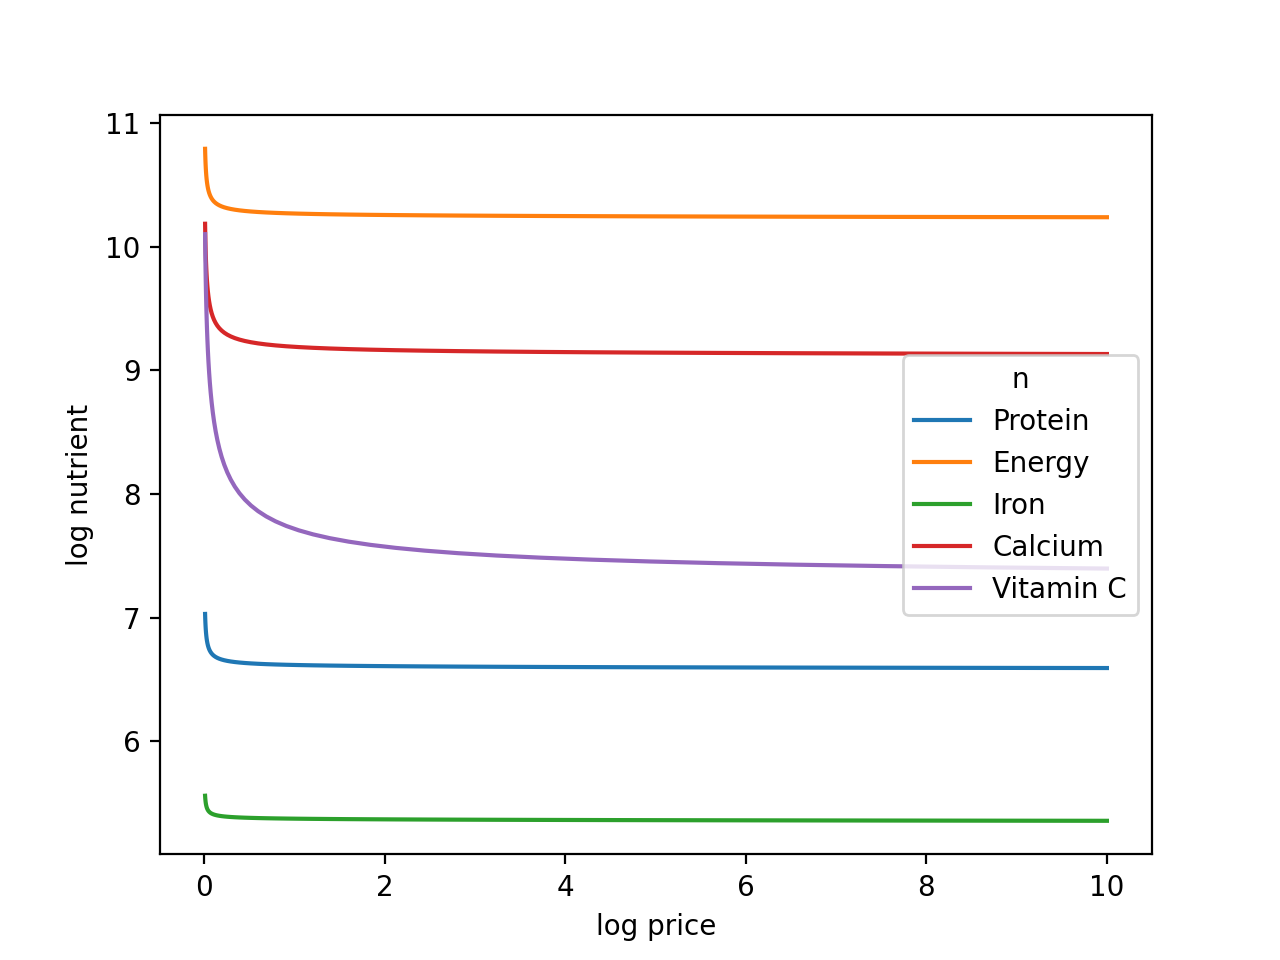

Text(0, 0.5, 'log nutrient')

In [19]:
USE_GOOD = 'Oranges'

scale = np.geomspace(.01,10,50)

ndf = pd.DataFrame({s:np.log(nutrient_demand(xref/2,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD)))[UseNutrients] for s in scale}).T

ax = ndf.plot()

ax.set_xlabel('log price')
ax.set_ylabel('log nutrient')

### Nutritional Needs of Households



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For the average household in our data, the number of
different kinds of people can be computed by averaging over households:



In [21]:
# In first round, averaged over households and villages
dbar = r.d.mean().iloc[:-2]

Now, the inner/dot/matrix product between `dbar` and the `rdi`
DataFrame of requirements will give us minimum requirements for the
average household:



In [22]:
# This matrix product gives minimum nutrient requirements for
# the average household
hh_rdi = rdi.replace('',0)@dbar

hh_rdi

n
Energy           9302.189239
Protein           207.761410
Fiber             130.230649
Folate           1742.820037
Calcium          5693.803340
Carbohydrate      692.063080
Iron               56.743228
Magnesium        1492.808905
Niacin             66.481633
Phosphorus       4292.437848
Potassium       23178.552876
Riboflavin          5.208200
Thiamin             5.059369
Vitamin A        3472.912801
Vitamin B-12       10.456920
Vitamin B-6         5.785158
Vitamin C         312.990724
Vitamin E          64.935436
Vitamin K         414.634508
Zinc               42.189610
dtype: float64

## Nutritional Adequacy of Food Demands



Since we can trace out demands for nutrients as a function of $(x,p)$,
and we&rsquo;ve computed minimum nutritional requirements for the average
household, we can *normalize* nutritional intake to check the adequacy
of diet for a household with counts of different kinds of people given by `z`.



In [23]:
def nutrient_adequacy_ratio(x,p,d,rdi=rdi,days=7):
    hh_rdi = rdi.replace('',0)@d*days

    return nutrient_demand(x,p)/hh_rdi

In terms of normalized nutrients, any household with more than one
unit of any given nutrient (or zero in logs) will be consuming a
minimally adequate level of the nutrient; below this level there&rsquo;s
clearly nutritional inadequacy.  For this reason the ratio of
actual nutrients to required nutrients is termed the &ldquo;nutrient
adequacy ratio,&rdquo; or NAR.



<IPython.core.display.Javascript object>


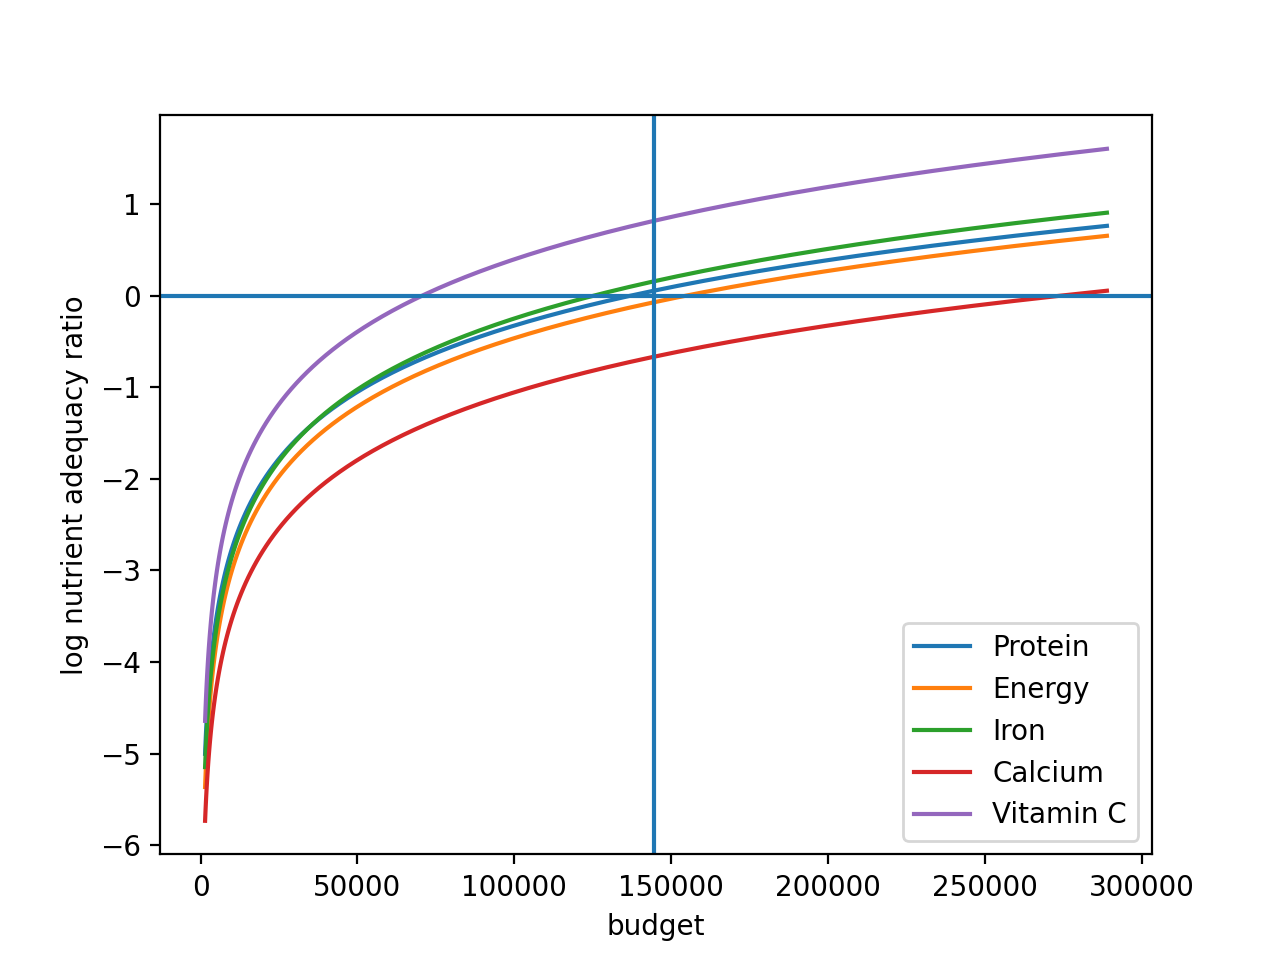

In [24]:
X = np.geomspace(.01*xref,2*xref,100)

pd.DataFrame({x:np.log(nutrient_adequacy_ratio(x,pbar,dbar))[UseNutrients] for x in X}).T.plot()
plt.legend(UseNutrients)
plt.xlabel('budget')
plt.ylabel('log nutrient adequacy ratio')
plt.axhline(0)
plt.axvline(xref)

As before, we can also vary relative prices.  Here we trace out
nutritional adequacy varying the price of a single good:



<IPython.core.display.Javascript object>


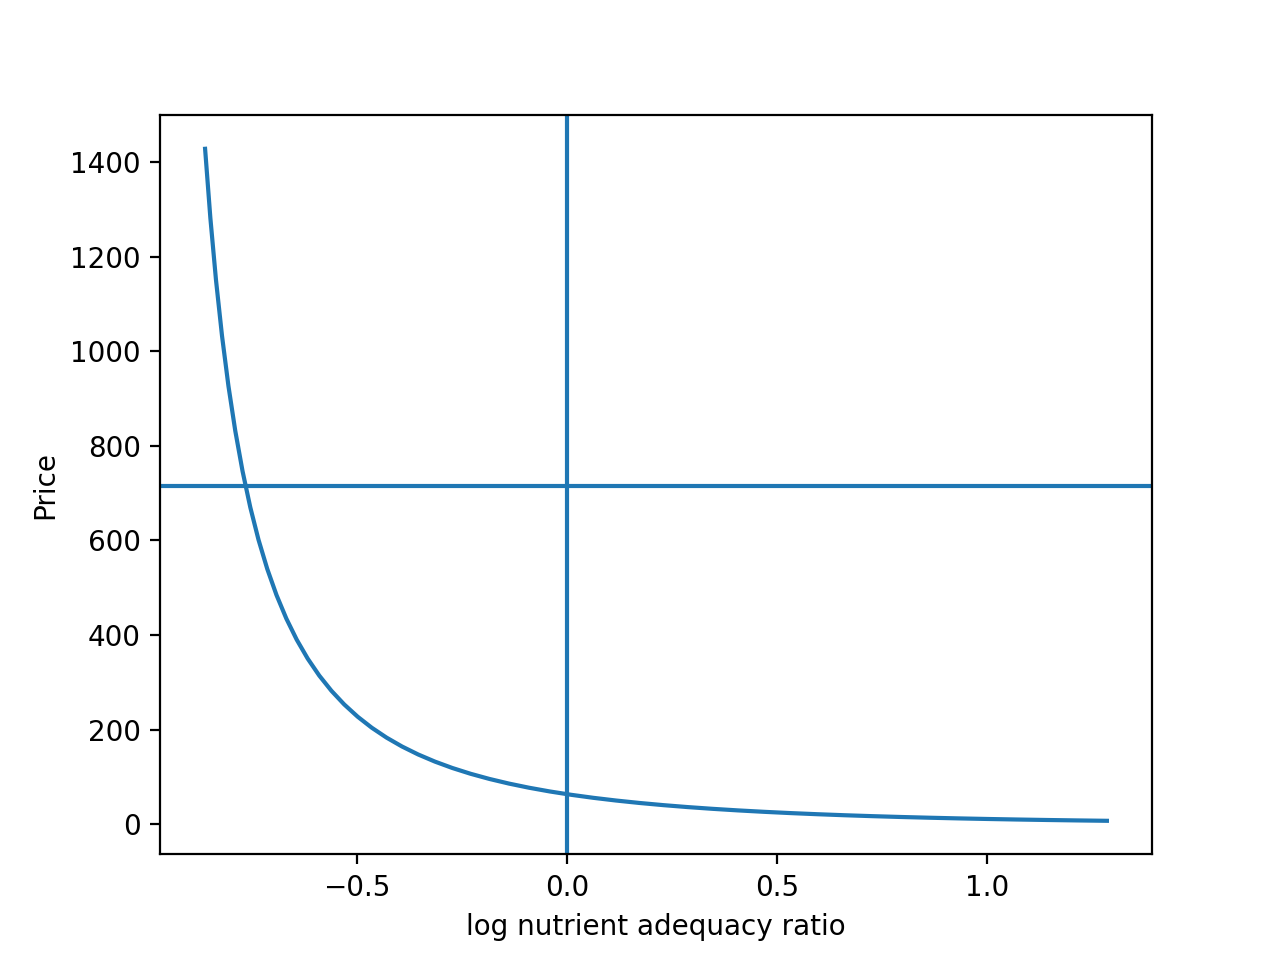

Text(0.5, 0, 'log nutrient adequacy ratio')

In [25]:
scale = np.geomspace(.01,2,50)

ndf = pd.DataFrame({s*pbar[USE_GOOD]:np.log(nutrient_adequacy_ratio(xref/4,my_prices(pbar[USE_GOOD]*s,j=USE_GOOD),dbar))[UseNutrients] for s in scale}).T

fig,ax = plt.subplots()
ax.plot(ndf['Vitamin C'],ndf.index)
ax.axhline(pbar[USE_GOOD])
ax.axvline(0)

ax.set_ylabel('Price')
ax.set_xlabel('log nutrient adequacy ratio')